# SENTIMENT ANALYSIS OF MOVIE REVIEWS # 

Importing the data-set

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import csv
import numpy as np

In [3]:
data_set = '/content/drive/MyDrive/HAP LAP/MAR&CEL/APPS/IMDB Dataset.csv'
data = pd.read_csv(data_set, sep=',')

In [4]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns


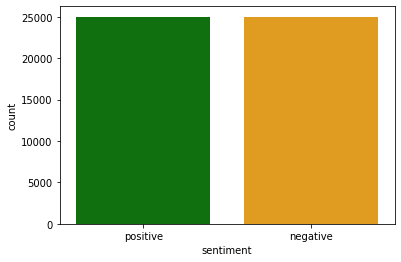

In [ ]:
#Checking whether the data-set is balanced

sns.countplot(x='sentiment', data=data, palette=['green',"orange"])

VISUALISING THE DATA-SET: Using wordclouds

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
positive= data[data.sentiment == 'positive']
text_pos = positive.review
negative = data[data.sentiment == 'negative']
text_neg = negative.review

In [ ]:
wordcloud= WordCloud(background_color='white',max_font_size = 50).generate(str(data.review))
wordcloud_pos= WordCloud(background_color='white',max_font_size = 50).generate(str(text_pos))
wordcloud_neg= WordCloud(background_color='white',max_font_size = 50).generate(str(text_neg))

Most frequent words in the data-set


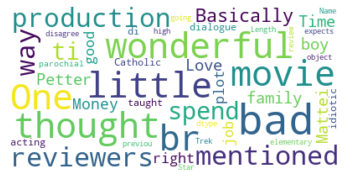

In [ ]:
print('Most frequent words in the data-set')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Most frequent words in the negative-labelled entries


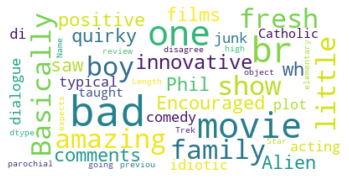

In [ ]:
print('Most frequent words in the negative-labelled entries')
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()



Most frequent words in the positive-labelled entries


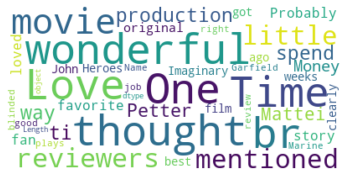

In [ ]:
print('Most frequent words in the positive-labelled entries')

plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()



PREPROCESSING

The data-set is quite clean, i.e., contains no emoticons and not many unknown symbols. For that reason, we will just perform lemmatisation and then remove stop-words and tokenise the data when using the vectorizer (TF-IDF).

In [27]:
import spacy
from spacy.lang.en.examples import sentences 
import string

def preprocess(data, remove_stopwords=True, remove_func_words=True):    
    nlp = spacy.load('en', disable=['parser', 'ner'])
    # Removing non functional words (articles, determiners)
    if remove_func_words:
        words = set(['NOUN', 'ADV', 'VERB','ADJ'])
        data['preproc'] = data['review'].apply(lambda row: [token.lemma_.lower() for token in nlp(row) if token.pos_ in words])
    else:
        data['preproc'] = data['review'].apply(lambda row: [token.lemma_.lower() for token in nlp(row)])
    
    # Removing stopwords
    if remove_stopwords:
        stop = nlp.Defaults.stop_words
        data['preproc'] = data['preproc'].apply(lambda row: [word for word in row if word not in stop])
        data['preproc'] = data['preproc'].apply(lambda row: [word for word in row if not all([c in string.punctuation for c in word])])
        extended_puntcation = '…–—«»'
        data['preproc'] = data['preproc'].apply(lambda row: [word for word in row if not all([c in extended_puntcation for c in word])])
        
    data['preproc'] = data['preproc'].apply(lambda row: ' '.join(row))
    return data

In [28]:
data = preprocess(data, remove_stopwords = True, remove_func_words= True)

In [29]:
data

,review,sentiment,preproc
0,One of the other reviewers has mentioned that ...,positive,reviewer mention watch oz episode hook right e...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,basically family little boy think zombie close...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,love visually stunning film watch offer vivid ...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,think movie right good job creative original e...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,teach parochial elementary school nun teach pr...
49998,I'm going to have to disagree with the previou...,negative,disagree previous comment second rate excessiv...


In [30]:
def data_as_numpy(data):
    return np.array(data.preproc),np.asarray(data.sentiment)


In [31]:
lemmas, sents = data_as_numpy(data)

In [33]:
vectorizer = TfidfVectorizer(strip_accents=None, #removes accents and other characters
lowercase=True, #all characters to lowercase
use_idf=True, # enable inverse-document-frequency reweighting
max_features=5000, #features to considered
min_df=5, #minimum frequency of words
max_df=0.7, #maximum frequency of words
#stop_words=stopwords Defined above
smooth_idf=True, #adding one to document frequencies
ngram_range=(1,2)) #using bigrams and unigrams

Vectorizing and splitting dataset

In [45]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import pickle

X_vec =vectorizer.fit_transform(lemmas).toarray()
pickle.dump(vectorizer.vocabulary_,open("feature.pkl","wb"))
Y = sents

#Selecting the 1000 best features for the predictions
selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X_vec, Y)


In [35]:
#Splitting the data-set: Selecting K features
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, random_state=1, test_size=0.3 )
X_training, X_dev, y_training, y_dev = train_test_split(X_train, y_train, random_state=1, test_size=0.4)


In [36]:
#Splitting the data-set: Not selecting features
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_vec, Y, random_state=1, test_size=0.3 )
X_training_2, X_dev_2, y_training_2, y_dev_2 = train_test_split(X_train_2, y_train_2, random_state=1, test_size=0.4)

CLASSIFICATION: NAIVE BAYES

In [37]:
#Evaluating on the developement set: Reduced number of features

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

NB = MultinomialNB()
NB.fit(X_training,y_training)
predictions = NB.predict(X_dev)
print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

    negative       0.88      0.83      0.85      7014
    positive       0.84      0.89      0.86      6986

    accuracy                           0.86     14000
   macro avg       0.86      0.86      0.86     14000
weighted avg       0.86      0.86      0.86     14000



In [38]:
#Evaluating on the developement set: Original number of features

NB = MultinomialNB()
NB.fit(X_training_2,y_training_2)
predictions = NB.predict(X_dev_2)
print(classification_report(y_dev_2,predictions))

              precision    recall  f1-score   support

    negative       0.87      0.83      0.85      7014
    positive       0.84      0.88      0.86      6986

    accuracy                           0.86     14000
   macro avg       0.86      0.86      0.86     14000
weighted avg       0.86      0.86      0.86     14000



Scores are better on the data with reduced number of features, so we use it for the final evaluation on the test.

In [39]:
#EVALUATING ON THE TEST SET

NB = MultinomialNB()
NB.fit(X_train,y_train)
predictions = NB.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    negative       0.88      0.85      0.86      7521
    positive       0.85      0.88      0.87      7479

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



Manually checking preformance: Examples from the data-set

In [41]:
print('Review:', data.review[11],'\nSentiment:',data.sentiment[11])
print('Predicted sentiment:', NB.predict(X_new[11].reshape(1,-1)))


Review: I saw this movie when I was about 12 when it came out. I recall the scariest scene was the big bird eating men dangling helplessly from parachutes right out of the air. The horror. The horror.<br /><br />As a young kid going to these cheesy B films on Saturday afternoons, I still was tired of the formula for these monster type movies that usually included the hero, a beautiful woman who might be the daughter of a professor and a happy resolution when the monster died in the end. I didn't care much for the romantic angle as a 12 year old and the predictable plots. I love them now for the unintentional humor.<br /><br />But, about a year or so later, I saw Psycho when it came out and I loved that the star, Janet Leigh, was bumped off early in the film. I sat up and took notice at that point. Since screenwriters are making up the story, make it up to be as scary as possible and not from a well-worn formula. There are no rules. 
Sentiment: negative
Predicted sentiment: ['negative']

In [42]:
print('Words with a higher TF-IDF in the sentence')
print('\n',vectorizer.inverse_transform(X_new[11]))


Words with a higher TF-IDF in the sentence

 [array(['active', 'advance', 'african american', 'art', 'art house',
       'background', 'belt', 'biker', 'bored', 'br look', 'breathe',
       'budget movie', 'bull', 'centre', 'chain', 'character film',
       'claim', 'cliché', 'colleague', 'comment film', 'connect',
       'conviction', 'crap', 'criticize', 'critter', 'crocodile'],
      dtype='<U21')]


New non-labelled examples

In [46]:
#Loading the vectorizer
transformer = TfidfTransformer()
loaded_vec = TfidfVectorizer(vocabulary=pickle.load(open("feature.pkl", "rb")))

#Positive review
sentence_1 = np.array(["I loved this film, it was amazing, although I expected some more action."])
vec_1 = transformer.fit_transform(loaded_vec.fit_transform(sentence_1))
vec_1_best = selector.transform(vec_1)

#Negative review
sentence_2 = np.array(['I was expecting something better from Woody Allen. The film was boring and slow'])
vec_2 = transformer.fit_transform(loaded_vec.fit_transform(sentence_2))
vec_2_best = selector.transform(vec_2)


In [48]:
print(sentence_1,'Predicted sentiment:', NB.predict(vec_1_best.toarray()))
print(sentence_2,'Predicted sentiment:', NB.predict(vec_2_best.toarray()))

['I loved this film, it was amazing, although I expected some more action.'] Predicted sentiment: ['positive']
['I was expecting something better from Woody Allen. The film was boring and slow'] Predicted sentiment: ['negative']


LEARNING CURVE

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import svm

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_new, Y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


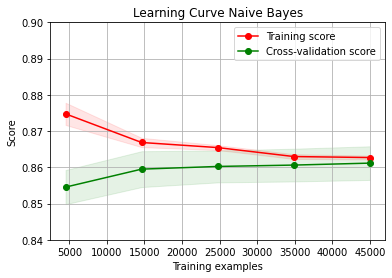

In [50]:
title = "Learning Curve Naive Bayes"

estimator = MultinomialNB()
plot_learning_curve(estimator, title, X_new, Y, ylim=(0.84, 0.90), cv=10, n_jobs=4)

plt.show()